## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import cmdstanpy 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import os
import json

from scipy.stats import gaussian_kde
import ipywidgets as widgets

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

## Choose Model

#### roots and global variables

In [3]:
root = './'
plots_root = root + 'Plots/'
datasets_root = root + 'Datasets/'
behavioural_data_root = root +  'behavioral_data/selected_data/' 
stan_files_root = root +  'stan files/' 
saved_models_root = root + 'stan_results/'

model_config = {}
plots_path = ''
dataset_path = ''
stan_file_path = ''
stan_output_dir = ''

#### read models configuration json file

In [4]:
with open("rdm_models.json") as f:
    models = json.load(f)
    models_name = list(models.keys())

#### Choose and set model configuration

In [5]:
def SetModelAndPaths(model_name):
    global model_config
    global plots_path
    global dataset_path
    global stan_file_path
    global stan_output_dir
    model_config = models[model_name]
    plots_path = plots_root + model_config['plots_folder_name'] + '/'
    dataset_path = datasets_root + model_config['dataset_name']
    stan_file_path = stan_files_root + model_config['stan_file']
    stan_output_dir = saved_models_root + model_config['model_name'] + '/'
    os.path
    
    if not os.path.exists(plots_path):
        os.makedirs(plots_path)
        print("Directory " , plots_path ,  " Created ")
    else:    
        print("Directory " , plots_path ,  " already exists")
        
    if not os.path.exists(stan_output_dir):
        os.makedirs(stan_output_dir)
        print("Directory " , stan_output_dir ,  " Created ")
    else:    
        print("Directory " , stan_output_dir ,  " already exists")

widgets.interact(SetModelAndPaths, model_name=models_name);

interactive(children=(Dropdown(description='model_name', options=('RDM', 'RDM_ct', 'RDM_cd', 'RDM_ndm', 'ANN-R…

In [6]:
model_config

{'model_name': 'RDM',
 'stan_file': 'RDM/RDM.stan',
 'dataset_name': 'fastText_subtlex_FT.csv',
 'plots_folder_name': 'RDM',
 'transf_params': ['transf_mu_drift_word',
  'transf_mu_drift_nonword',
  'transf_mu_threshold',
  'transf_mu_ndt']}

## Prepare data

Loading words and non-words with zipf and predicted probabilities

In [7]:
word_nword_df = pd.read_csv(dataset_path, header=None, names =['string', 'freq',  'label', 'zipf','category', 'word_prob', 'non_word_prob'])
word_nword_df

,string,freq,label,zipf,category,word_prob,non_word_prob
0,cornbread,140,1,2.963932,LF,9.994057e-01,0.000594
1,pains,2259,1,3.723198,HF,9.999964e-01,0.000004
2,quivers,84,1,2.467925,LF,9.949029e-01,0.005097
3,cutback,67,1,2.547107,LF,9.994540e-01,0.000546
4,pourn,0,0,0.000000,NW,7.554672e-06,0.999992
...,...,...,...,...,...,...,...
74312,beacan,0,0,0.000000,NW,1.223383e-08,1.000000
74313,unsold,255,1,2.194924,LF,9.999645e-01,0.000035
74314,imitating,469,1,3.260317,HF,9.998357e-01,0.000164
74315,evidence,62334,1,4.928923,HF,9.994597e-01,0.000540


In [8]:
def remove_outliers(df, max_rt, min_rt, std_c=2.5):
    """
    Returns remove outliers from dataframes. Outlier RTs are bigger than
    max_rt and smaller than min_rt. Also RTsthat are out of -/+ (std_c * sd) 
    of mean RT interval are considered as outliers too.

    Parameters
    ----------
        df: pandas dataframe with rt column
        max_rt (float): maximum acceptable rt
        min_rt (float): minimum acceptable rt
        
    Optional Parameters
    ----------
        std_c (float) : Optional
            coefficient to define interval of non-outlier RTs
    
    Returns
    -------
        df: pandas dataframe without outliers  
    """
    mean = df['rt'].mean()
    sd = df['rt'].std()
    lower_thr = mean - std_c*sd
    upper_thr = mean + std_c*sd
    min_bound = max(min_rt, lower_thr)
    max_bound = min(max_rt, upper_thr)
    df = df[df['rt'] >= min_bound]
    df = df[df['rt'] <= max_bound]
    return df

Reading and modifing each behavioral data file and combining all of them into a single behavioral dataframe

In [9]:
Number_Of_Participants = 5
Number_Of_Trials = 400
dataframes = []

for i in range(Number_Of_Participants):
    # Loading each file
    df = pd.read_csv(behavioural_data_root + str(i+1) + "DATA.LDT", names=['trial', 'string_id', 'string_type', 'accuracy', 'rt', 'string'])
    # Dropping non rows and first two rows that are demographic informations 
    df = df.dropna().drop('string_id', axis=1).drop([0, 1]).iloc[:Number_Of_Trials] 
    # Converting columns type to suitable data types
    convert_dict = {'string_type': 'int16',
                    'accuracy': 'int16',
                    'rt': float
                   }

    df = df.astype(convert_dict)
    # Convert RTs to seconds
    df['rt'] = df['rt'].apply(lambda x: x/1000) 
    # Removing Outliers
    df = remove_outliers(df, 3, .2, 2.5)
    # Extracting response of participant from his/her accuracy
    df['response'] = np.logical_not(np.logical_xor(df['string_type'], df['accuracy'])).astype('int')
    df = df.reset_index(drop=True)
    # Particpant number
    df['participant'] = i+1
    # Minimum RT of participant in all trials (is needed for stan code)
    df['minRT'] = df['rt'].min()
    dataframes.append(df)

In [10]:
# Combining dataframes
behavioural_df = pd.concat(dataframes)
# Merging  behavioral dataframe with word_nonword_df to have words and non-words data with behavioral data
behavioural_df = pd.merge(behavioural_df, word_nword_df, on='string', how='left').dropna().reset_index(drop=True)
behavioural_df = behavioural_df.drop(["trial", "string_type", "freq"], axis=1)

In [11]:
behavioural_df.head()

,accuracy,rt,string,response,participant,minRT,label,zipf,category,word_prob,non_word_prob
0,0,0.707,bookie,0,1,0.412,1.0,3.409105,HF,9.982517e-01,0.001748
1,1,0.769,gandbrake,0,1,0.412,0.0,0.000000,NW,3.736372e-08,1.000000
2,1,0.526,philosophical,1,1,0.412,1.0,3.205648,HF,9.968132e-01,0.003187
3,0,0.510,umbeaten,1,1,0.412,0.0,0.000000,NW,5.537812e-05,0.999945
4,1,0.512,belonging,1,1,0.412,1.0,3.317140,HF,9.985624e-01,0.001438


Predicted probabilities of words and non-words in different conditions in all trials
across participants

In [12]:
behavioural_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'], 'non_word_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                         non_word_prob  \
              mean       std count       max           min          mean   
category                                                                   
HF        0.992733  0.050218   363  1.000000  1.081290e-01      0.007267   
LF        0.987004  0.063322   491  1.000000  4.057633e-09      0.012996   
NW        0.004349  0.049290   933  0.946264  7.235630e-26      0.995651   

                                                  
               std count       max           min  
category                                          
HF        0.050218   363  0.891871  6.759641e-13  
LF        0.063322   491  1.000000  5.270731e-10  
NW        0.049290   933  1.000000  5.373600e-02

RT and response description of words and non-words in different conditions in all trials
across participants

In [13]:
behavioural_df.groupby(['category']).agg({'rt': ['mean', 'std', 'max', 'min'], 'response': ['mean', 'std', 'max', 'min']})

rt                          response                  
              mean       std    max    min      mean       std max min
category                                                              
HF        0.599548  0.191587  1.660  0.301  0.953168  0.211570   1   0
LF        0.691642  0.217314  1.707  0.271  0.861507  0.345769   1   0
NW        0.740148  0.225628  1.763  0.200  0.143623  0.350895   1   0

## Stan Model and Estimation

Compiling stan model

In [14]:
rdm_model = cmdstanpy.CmdStanModel(model_name=model_config['model_name'],
                                   stan_file=stan_file_path)

15:24:19 - cmdstanpy - INFO - compiling stan file D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan files\RDM\RDM.stan to exe file D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan files\RDM\RDM.exe
15:24:42 - cmdstanpy - INFO - compiled model executable: D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan files\RDM\RDM.exe
15:24:42 - cmdstanpy - WARNING - Stan compiler has produced 14 warnings:
15:24:42 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/Lenovo/AppData/Local/Temp/tmpe228l57k/tmp_l21xx7j.hpp C:/Users/Lenovo/AppData/Local/Temp/tmpe228l57k/tmp_l21xx7j.stan
Warning in 'C:/Users/Lenovo/AppData/Local/Temp/tmpe228l57k/tmp_l21xx7j.stan', line 54, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/Users/Lenovo/AppData/Loc

Preparing model's inputs

note that some inputs of data_dict might not be used depending on which model is used

In [15]:
N = len(behavioural_df)                                                    # For all models
participant = behavioural_df['participant'].to_numpy()                     # For all models
p = behavioural_df.loc[:, ['word_prob', 'non_word_prob']].to_numpy()       # predicted probabilites of words and non-words, for ANN-EAM models
frequency = behavioural_df['zipf'].to_numpy().astype(int)                  # zipf values, for models with non-decision time or drift modulation
frequencyCondition = behavioural_df['category'].replace(["HF", "LF", "NW"], [1, 2, 3]).to_numpy() # For models with conditional drift
response = behavioural_df['response'].to_numpy().astype(int)               # for all models
rt = behavioural_df['rt'].to_numpy()                                       # for all models
minRT = behavioural_df['minRT'].to_numpy()                                 # for all models
RTbound = 0.1                                                              # for all models

threshold_priors = [0, 1, 1, 1]          # For all models with LBA
ndt_priors = [0, 1, 1, 1];               # For models wtihout non-decision time modulation
g_priors = [-2, 1, 0, 1]                 # For models wtih non-decision time modulation
m_priors = [0, 0.5, 0, 1]                # For models wtih non-decision time modulation
drift_priors = [1, 2, 1, 1]              # For models without drift mapping functions (non ANN-EAM models)
alpha_priors = [0, 1, 1, 1]              # For models with drift mapping functions
b_priors = [0, 1, 1, 1]                  # For models with drift mapping functions with asymptote modulation and linear models
k_priors = [2, 1, 1, 1]                  # For models with sigmoid drift mapping functions (ANN-EAM models)

# define input for the model
data_dict = {'N': N,
             'L': Number_Of_Participants,
             'participant': participant,
             'response': response,
             'rt': rt,
             'minRT': minRT,
             'RTbound': RTbound,
             'frequency': frequency,
             'frequencyCondition': frequencyCondition,
             'threshold_priors': threshold_priors,
             'ndt_priors': ndt_priors,
             'g_priors': g_priors,
             'm_priors': m_priors,
             'drift_priors': drift_priors,
             'p': p,
             'alpha_priors': alpha_priors,
             'b_priors': b_priors,
             'k_priors': k_priors,
             }

# set sampling parameters
n_iter = 500
n_warmup = int(n_iter/2)
n_sample = int(n_iter/2)
n_chains = 2

Fitting the model

In [16]:
fit = rdm_model.sample(data=data_dict,
                       iter_sampling=n_sample, 
                       iter_warmup=n_warmup,
                       chains=n_chains,
                       output_dir=stan_output_dir,
                       show_console=True)

15:25:07 - cmdstanpy - INFO - Chain [1] start processing
15:25:07 - cmdstanpy - INFO - Chain [2] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 250
Chain [1] num_warmup = 250
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = C:\Users\Lenovo\AppData\Local\Temp\tmptevhkvk_\aesgxrtg.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] seed = 99852
Chain [1] out

15:29:22 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] 
Chain [1] Elapsed Time: 139.623 seconds (Warm-up)
Chain [1] 115.638 seconds (Sampling)
Chain [1] 255.261 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [2] Iteration: 500 / 500 [100%]  (Sampling)


15:29:29 - cmdstanpy - INFO - Chain [2] done processing


Chain [2] 
Chain [2] Elapsed Time: 167.099 seconds (Warm-up)
Chain [2] 95.679 seconds (Sampling)
Chain [2] 262.778 seconds (Total)
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 


15:29:30 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 2 divergent transitions (0.8%)
	Use function "diagnose()" to see further information.


## Model diagnostics

In [17]:
print("***hmc diagnostics:")
print(fit.diagnose(), flush=True)

***hmc diagnostics:
Processing csv files: D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan_results\RDM\RDM-20220904152507_1.csv, D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan_results\RDM\RDM-20220904152507_2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
2 of 500 (0.40%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.



In [18]:
df = fit.summary()

print("***DF: ")
df

***DF: 


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-479.650000,0.795425,5.653420,-489.094000,-479.282000,-470.730000,50.5155,0.239051,1.037660
mu_ndt,-1.186640,0.049522,0.696916,-2.247100,-1.161170,0.041690,198.0410,0.937176,1.000110
mu_threshold,1.803440,0.015974,0.236079,1.349850,1.835590,2.132660,218.4320,1.033670,1.008600
mu_drift_word,2.992870,0.034637,0.587126,2.011650,3.053630,3.953250,287.3310,1.359710,0.998165
mu_drift_nonword,2.790870,0.041352,0.562882,1.793850,2.811480,3.678200,185.2820,0.876797,1.016780
...,...,...,...,...,...,...,...,...,...
log_lik[1783],-2.124940,0.005715,0.124724,-2.343730,-2.122210,-1.923710,476.3470,2.254180,0.997136
log_lik[1784],-0.068861,0.003261,0.072834,-0.187159,-0.069044,0.042385,498.9580,2.361180,1.000360
log_lik[1785],0.005893,0.002947,0.066959,-0.102137,0.008412,0.109989,516.3890,2.443670,0.999521
log_lik[1786],-2.783080,0.008110,0.167669,-3.068760,-2.777950,-2.515080,427.4660,2.022870,0.997819


In [19]:
counter = 0
print("***Rhat > 1.01: ")
for f in df["R_hat"]:
    if f >= 1.01 or f <= 0.9:
        counter+=1
print(counter)

***Rhat > 1.01: 
726


In [20]:
df.loc[df['R_hat']>1.01]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-479.650000,0.795425,5.653420,-489.094000,-479.282000,-470.730000,50.5155,0.239051,1.03766
mu_drift_nonword,2.790870,0.041352,0.562882,1.793850,2.811480,3.678200,185.2820,0.876797,1.01678
z_threshold[5],-0.472049,0.057200,0.800109,-1.826560,-0.370688,0.692940,195.6610,0.925910,1.01002
z_drift_nonword[1],0.456976,0.028835,0.468663,-0.362099,0.446843,1.201270,264.1600,1.250070,1.01185
z_drift_nonword[5],-0.496921,0.035567,0.516660,-1.379660,-0.460140,0.362047,211.0160,0.998574,1.01955
...,...,...,...,...,...,...,...,...,...
log_lik[1279],-1.240530,0.010267,0.229258,-1.628830,-1.231000,-0.902443,498.6110,2.359540,1.01712
log_lik[1285],-1.087000,0.008907,0.204208,-1.448380,-1.079750,-0.780301,525.6150,2.487330,1.01542
log_lik[1288],-1.267350,0.010524,0.233915,-1.665440,-1.257450,-0.921493,494.0260,2.337840,1.01738
log_lik[1302],-0.733126,0.006540,0.156891,-1.019670,-0.726261,-0.489050,575.5380,2.723580,1.01051


In [21]:
df.loc[df['R_hat']>1.01].describe()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
count,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000
mean,-0.542050,0.003974,0.043574,-0.612155,-0.542984,-0.467503,126.078957,0.596634,1.017611
std,17.821976,0.030461,0.229268,18.178589,17.807844,17.489608,57.462103,0.271924,0.003563
min,-479.650000,0.000989,0.008852,-489.094000,-479.282000,-470.730000,50.515500,0.239051,1.010020
25%,0.108393,0.000989,0.008852,0.100511,0.105822,0.128913,80.191900,0.379486,1.014160
50%,0.108393,0.003346,0.042834,0.100511,0.105822,0.128913,163.864000,0.775442,1.017145
75%,0.222117,0.003346,0.042834,0.154416,0.220039,0.296622,163.864000,0.775442,1.021070
max,2.860110,0.795425,5.653420,1.947700,2.869860,3.703160,575.538000,2.723580,1.037660


## Check parameters

Loading Model

In [22]:
# fit = cmdstanpy.from_csv(stan_output_dir)

Parameters posterior plots

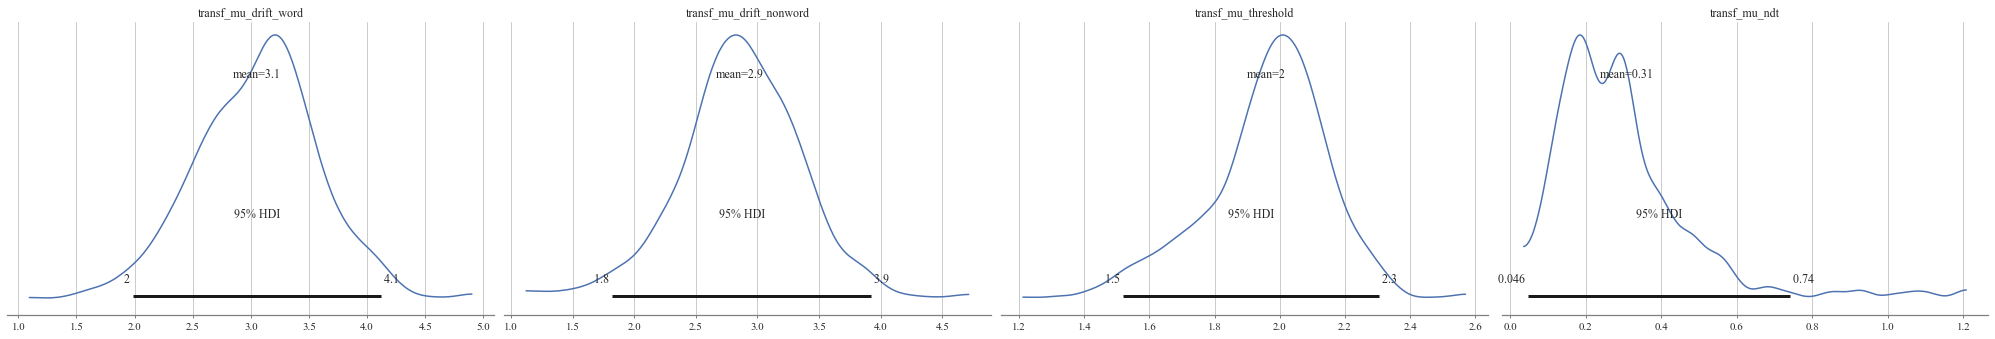

In [23]:
az.plot_posterior(fit, var_names=model_config['transf_params'], hdi_prob=.95);
plt.savefig(plots_path + 'Parameters.pdf')

In [25]:
# Loading model parameters for each trial
drift_word_t = fit.stan_variables()['drift_word_t']
drift_nonword_t = fit.stan_variables()['drift_nonword_t']
if model_config['model_name'] != "RDM":
    threshold_t_word = fit.stan_variables()['threshold_t_word']
    threshold_t_nonword = fit.stan_variables()['threshold_t_nonword']
else:
    threshold_t = fit.stan_variables()['threshold_t']
ndt_t = fit.stan_variables()['ndt_t']

#### Models mean parameters in different conditions

In [26]:
HF_condition_w = drift_word_t[:, behavioural_df['category']=="HF"]
HF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="HF"]
LF_condition_w = drift_word_t[:, behavioural_df['category']=="LF"]
LF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="LF"]
NW_condition_w = drift_word_t[:, behavioural_df['category']=="NW"]
NW_condition_nw = drift_nonword_t[:, behavioural_df['category']=="NW"]

In [27]:
print('HF words, word drift mean and std:')
print(np.mean(np.mean(HF_condition_w, axis=1)), np.std(np.mean(HF_condition_w, axis=1)))
print('HF words, nonword drift mean and std:')
print(np.mean(np.mean(HF_condition_nw, axis=1)), np.std(np.mean(HF_condition_nw, axis=1)))
print('LF words word drift mean and std:')
print(np.mean(np.mean(LF_condition_w, axis=1)), np.std(np.mean(LF_condition_w, axis=1)))
print('LF words nonword drift mean and std:')
print(np.mean(np.mean(LF_condition_nw, axis=1)), np.std(np.mean(LF_condition_nw, axis=1)))
print('NW words word drift mean and std:')
print(np.mean(np.mean(NW_condition_w, axis=1)), np.std(np.mean(NW_condition_w, axis=1)))
print('NW words nonword drift mean and std:')
print(np.mean(np.mean(NW_condition_nw, axis=1)), np.std(np.mean(NW_condition_nw, axis=1)))

HF words, word drift mean and std:
3.2407548731129467 0.1338557651524165
HF words, nonword drift mean and std:
3.0806189279889797 0.12746307543201382
LF words word drift mean and std:
3.1902341683095714 0.13343497942184745
LF words nonword drift mean and std:
3.040342364847249 0.12665734075963384
NW words word drift mean and std:
3.1925209873097566 0.1317475287841652
NW words nonword drift mean and std:
3.0411614732261536 0.12517753696608788


In [28]:
if model_config['model_name'] != "RDM":
    HF_condition_w = threshold_t_word[:, behavioural_df['category']=="HF"]
    HF_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="HF"]
    LF_condition_w = threshold_t_word[:, behavioural_df['category']=="LF"]
    LF_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="LF"]
    NW_condition_w = threshold_t_word[:, behavioural_df['category']=="NW"]
    NW_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="NW"]
else:
    HF_condition = threshold_t[:, behavioural_df['category']=="HF"]
    LF_condition = threshold_t[:, behavioural_df['category']=="LF"]
    NW_condition = threshold_t[:, behavioural_df['category']=="NW"]

In [29]:
if model_config['model_name'] != "RDM":
    print('HF words, word threshold mean and std:')
    print(np.mean(np.mean(HF_condition_w, axis=1)), np.std(np.mean(HF_condition_w, axis=1)))
    print('HF words, nonword threshold mean and std:')
    print(np.mean(np.mean(HF_condition_nw, axis=1)), np.std(np.mean(HF_condition_nw, axis=1)))
    print('LF words word threshold mean and std:')
    print(np.mean(np.mean(LF_condition_w, axis=1)), np.std(np.mean(LF_condition_w, axis=1)))
    print('LF words nonword threshold mean and std:')
    print(np.mean(np.mean(LF_condition_nw, axis=1)), np.std(np.mean(LF_condition_nw, axis=1)))
    print('NW words word threshold mean and std:')
    print(np.mean(np.mean(NW_condition_w, axis=1)), np.std(np.mean(NW_condition_w, axis=1)))
    print('NW words nonword threshold mean and std:')
    print(np.mean(np.mean(NW_condition_nw, axis=1)), np.std(np.mean(NW_condition_nw, axis=1)))
else:
    print('HF words, threshold mean and std:')
    print(np.mean(np.mean(HF_condition, axis=1)), np.std(np.mean(HF_condition, axis=1)))
    print('LF words, threshold mean and std:')
    print(np.mean(np.mean(LF_condition, axis=1)), np.std(np.mean(LF_condition, axis=1)))
    print('NW words, word threshold mean and std:')
    print(np.mean(np.mean(NW_condition, axis=1)), np.std(np.mean(NW_condition, axis=1)))

HF words, threshold mean and std:
2.008298354545455 0.12101721507666074
LF words, threshold mean and std:
2.0034071598370673 0.12221630121918112
NW words, word threshold mean and std:
2.003864282036442 0.12001910505096927


In [30]:
HF_condition = ndt_t[:, behavioural_df['category']=="HF"]
LF_condition = ndt_t[:, behavioural_df['category']=="LF"]
NW_condition = ndt_t[:, behavioural_df['category']=="NW"]

In [31]:
print('HF words ndt_t mean and std:')
print(np.mean(np.mean(HF_condition, axis=1)), np.std(np.mean(HF_condition, axis=1)))

HF words ndt_t mean and std:
0.16678713799449033 0.018708418650502233


In [32]:
print('LF words ndt_t mean and std:')
print(np.mean(np.mean(LF_condition, axis=1)), np.std(np.mean(LF_condition, axis=1)))

LF words ndt_t mean and std:
0.16727037000814662 0.019074322440874085


In [33]:
print('Non Words ndt_t mean and std:')
print(np.mean(np.mean(NW_condition, axis=1)), np.std(np.mean(NW_condition, axis=1)))

Non Words ndt_t mean and std:
0.16603322864737408 0.01875069899225254


## Calculating metrics

In [34]:
def calculate_waic(log_likelihood, pointwise=False):
    """
    Returns model comparisions' metrics.
    
    Parameters
    ----------
        log_likelihood: np.array
            log_likelihood of each trial
        max_rt: float
            maximum acceptable rt
        min_rt: float
             minimum acceptable rt
             
    Optional Parameters
    ----------------
    pointwise: float
        if true pointwise waic will be calculated
        
    Returns
    -------
        out:  a dictionary containing lppd, waic, waic_se and pointwise_waic    
    """
    likelihood = np.exp(log_likelihood)

    mean_l = np.mean(likelihood, axis=0) # N observations

    pointwise_lppd = np.log(mean_l)
    lppd = np.sum(pointwise_lppd)

    pointwise_var_l = np.var(log_likelihood, axis=0) # N observations
    var_l = np.sum(pointwise_var_l)

    pointwise_waic = - 2*pointwise_lppd +  2*pointwise_var_l
    waic = -2*lppd + 2*var_l
    waic_se = np.sqrt(log_likelihood.shape[1] * np.var(pointwise_waic))

    if pointwise:
        out = {'lppd':lppd,
               'p_waic':var_l,
               'waic':waic,
               'waic_se':waic_se,
               'pointwise_waic':pointwise_waic}
    else:
        out = {'lppd':lppd,
               'p_waic':var_l,
                'waic':waic,
                'waic_se':waic_se}
    return out

In [35]:
log_likelihood = fit.stan_variables()['log_lik']
print(calculate_waic(log_likelihood))

{'lppd': -455.91186988377353, 'p_waic': 20.22490206712392, 'waic': 952.2735439017949, 'waic_se': 79.86664402269564}


## Simulating RDM with estimated parameters

In [36]:
def random_rdm_2A(cor_drift, inc_drift, threshold_word, threshold_nonword, ndt, noise_constant=1, dt=0.001, max_rt=10):
    """ 
    Simulates behavior (rt and accuracy) according to the Racing Diffusion Model.
     
    Parameters
    ----------
    cor_drift : numpy.ndarray
        Drift-rate of the Racing Diffusion Model - correct trials.
    inc_drift : numpy.ndarray
        Drift-rate of the Racing Diffusion Model - incorrect trials.
    threshold : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Threshold of the diffusion decision model.
    ndt : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Non decision time of the diffusion decision model, in seconds.
    
    Optional Parameters
    ----------------
    noise_constant : float, default 1
        Scaling factor of the Racing Diffusion Model.
        If changed, drift and threshold would be scaled accordingly.
        Not to be changed in most applications.
    dt : float, default 0.001
        Controls the time resolution of the Racing Diffusion Model. Default is 1 msec.
        Lower values of dt make the function more precise but much slower.
    max_rt : float, default 10
        Controls the maximum rts that can be predicted.
        Making this higher might make the function a bit slower.
    
    Returns
    -------
    rt : numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated response times according to the Racing Diffusion Model.
        Every element corresponds to the set of parameters given as input with the same shape.
    acc: numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated accuracy according to the Racing Diffusion Model.
        Every element corresponds to the set of parameters given as input with the same shape.
    """
    shape = cor_drift.shape
    acc = np.empty(shape)
    rt = np.empty(shape)
    acc[:] = np.nan
    rt[:] = np.nan

    max_tsteps = max_rt/dt

    x_cor = np.zeros(shape)
    x_inc = np.zeros(shape)

    tstep = 0
    ongoing = np.array(np.ones(shape), dtype=bool)

    stop_race = False

    while np.sum(ongoing) > 0 and tstep < max_tsteps:
        x_cor[ongoing] += np.random.normal(cor_drift[ongoing]*dt,
                                           noise_constant*np.sqrt(dt),
                                           np.sum(ongoing))
        x_inc[ongoing] += np.random.normal(inc_drift[ongoing]*dt,
                                           noise_constant*np.sqrt(dt),
                                           np.sum(ongoing))
        tstep += 1
        ended_correct = (x_cor >= threshold_word)
        ended_incorrect = (x_inc >= threshold_nonword)

        # store results and filter out ended trials
        if np.sum(ended_correct) > 0:
            acc[np.logical_and(ended_correct, ongoing)] = 1
            rt[np.logical_and(ended_correct, ongoing)] = dt*tstep + ndt[np.logical_and(ended_correct, ongoing)]
            ongoing[ended_correct] = False

        if np.sum(ended_incorrect) > 0:
            acc[np.logical_and(ended_incorrect, ongoing)] = 0
            rt[np.logical_and(ended_incorrect, ongoing)] = dt*tstep + ndt[np.logical_and(ended_incorrect, ongoing)]
            ongoing[ended_incorrect] = False
    return rt, acc

Simulating RDM with estimated parameters

In [37]:
if model_config['model_name'] != "RDM":
    pp_rt, pp_response = random_rdm_2A(drift_word_t, drift_nonword_t, threshold_t_word, threshold_t_nonword, ndt_t, noise_constant=1, dt=0.001, max_rt=5)
else:
    pp_rt, pp_response = random_rdm_2A(drift_word_t, drift_nonword_t, threshold_t, threshold_t, ndt_t, noise_constant=1, dt=0.001, max_rt=5)

In [38]:
def bci(x, alpha=0.05):
    """
    Calculate Bayesian credible interval (BCI).
    
    Parameters
    ----------
    x : array-like
        An array containing MCMC samples.
    
    Optional Parameters
    -------------------
    alpha : float, default 0.05
        Desired probability of type I error.
    
    Returns
    -------
    interval : numpy.ndarray
        Array containing the lower and upper bounds of the bci interval.
    """
    interval = np.nanpercentile(x, [(alpha/2)*100, (1-alpha/2)*100])

    return interval

In [39]:
# Predicted Data
rt_predictions = pd.concat((pd.DataFrame(pp_rt, index=pd.Index(np.arange(1, len(pp_rt)+1))).T, behavioural_df['category']), axis=1)
response_predictions = pd.concat((pd.DataFrame(pp_response, index=pd.Index(np.arange(1, len(pp_response)+1))).T, behavioural_df['category']), axis=1)

# Experiment Data
experiment_data = behavioural_df.loc[:, ['rt', 'response', 'category']]

Separating RT and Response of predicted and experimental data for each condition

In [40]:
HF_data = experiment_data.loc[experiment_data['category']=='HF']
LF_data = experiment_data.loc[experiment_data['category']=='LF']
NW_data = experiment_data.loc[experiment_data['category']=='NW']

HF_pred_rt = rt_predictions.loc[rt_predictions['category']=='HF'].drop(['category'], axis=1)
HF_pred_resp = response_predictions.loc[response_predictions['category']=='HF'].drop(['category'], axis=1)
LF_pred_rt = rt_predictions.loc[rt_predictions['category']=='LF'].drop(['category'], axis=1)
LF_pred_resp = response_predictions.loc[response_predictions['category']=='LF'].drop(['category'], axis=1)
NW_pred_rt = rt_predictions.loc[rt_predictions['category']=='NW'].drop(['category'], axis=1)
NW_pred_resp = response_predictions.loc[response_predictions['category']=='NW'].drop(['category'], axis=1)

## Quantiles Posterior Predictions

In [41]:
quantiles = [.1, .3, .5, .7, .9]
percentiles = np.array(quantiles)*100

In [42]:
# experiment Data quantile
HF_quantile_ex = HF_data['rt'].quantile(quantiles)
LF_quantile_ex = LF_data['rt'].quantile(quantiles)
NW_quantile_ex = NW_data['rt'].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_quantile_pred = HF_pred_rt.quantile(quantiles, axis=0).T
LF_quantile_pred = LF_pred_rt.quantile(quantiles, axis=0).T
NW_quantile_pred = NW_pred_rt.quantile(quantiles, axis=0).T

# predicted data quantiles bci
HF_predicted_bci = np.array([bci(HF_quantile_pred[x]) for x in quantiles])
LF_predicted_bci = np.array([bci(LF_quantile_pred[x]) for x in quantiles])
NW_predicted_bci = np.array([bci(NW_quantile_pred[x]) for x in quantiles])

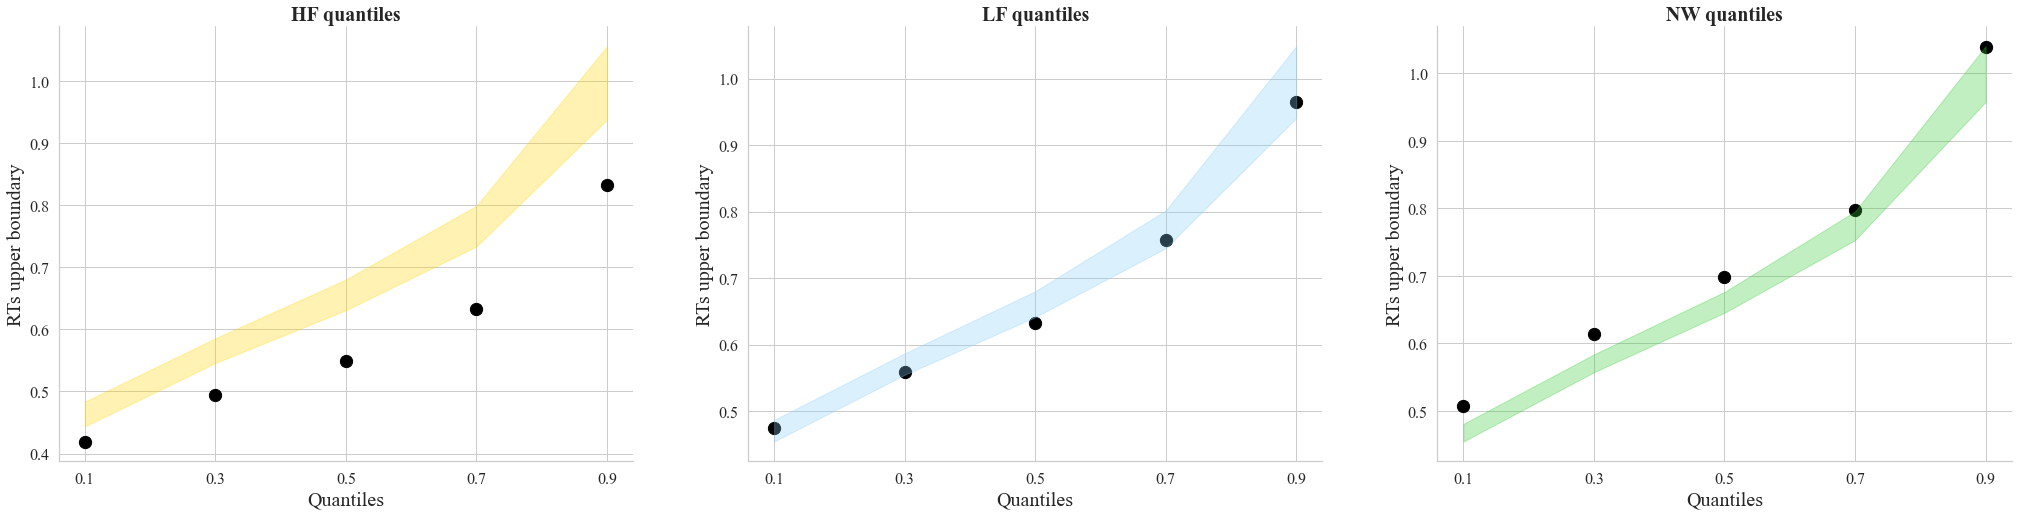

In [43]:
fig, axes = plt.subplots(1,3 , figsize=(35,8))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title('HF quantiles', fontweight="bold", size=20)
axes[1].set_title('LF quantiles', fontweight="bold", size=20)
axes[2].set_title('NW quantiles', fontweight="bold", size=20)

axes[0].scatter(quantiles, HF_quantile_ex, color='black', s=150)
axes[1].scatter(quantiles, LF_quantile_ex, color='black', s=150)
axes[2].scatter(quantiles, NW_quantile_ex, color='black', s=150)

axes[0].fill_between(quantiles,
                HF_predicted_bci[:, 0],
                HF_predicted_bci[:, 1],
                HF_predicted_bci[:, 0] < HF_predicted_bci[:, 1],  color = 'gold', alpha=0.3)

axes[1].fill_between(quantiles,
                LF_predicted_bci[:, 0],
                LF_predicted_bci[:, 1],
                LF_predicted_bci[:, 0] < LF_predicted_bci[:, 1],  color = 'lightskyblue', alpha=0.3)

axes[2].fill_between(quantiles,
                NW_predicted_bci[:, 0],
                NW_predicted_bci[:, 1],
                NW_predicted_bci[:, 0] < NW_predicted_bci[:, 1],  color = 'limegreen', alpha=0.3)


for ax in axes:
        ax.set_xlabel('Quantiles', fontsize=20)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RTs upper boundary', fontsize=20)
        for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(16)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(16) 

sns.despine()
plt.savefig(plots_path + 'Quantiles Poseterior.pdf')

## Mean Accuracy and RT Posterior Plots

In [44]:
HF_data_rt_mean = HF_data['rt'].mean()
LF_data_rt_mean = LF_data['rt'].mean()
NW_data_rt_mean = NW_data['rt'].mean()

HF_pred_rt_mean = HF_pred_rt.mean(axis=0)
LF_pred_rt_mean = LF_pred_rt.mean(axis=0)
NW_pred_rt_mean = NW_pred_rt.mean(axis=0)


HF_data_resp_mean = HF_data['response'].mean()
LF_data_resp_mean = LF_data['response'].mean()
NW_data_resp_mean = NW_data['response'].mean()

HF_pred_resp_mean = HF_pred_resp.mean(axis=0)
LF_pred_resp_mean = LF_pred_resp.mean(axis=0)
NW_pred_resp_mean = NW_pred_resp.mean(axis=0)


In [45]:
def plot_posterior(x, data_mean, ax):
    """
    Plots the posterior of x with experimental data mean as a line
    
    Parameters
    ----------
    x : array-like
        An array containing RT or response for each trial.
        
    x : float
        mean of RT or Accuracy of experimental data.

    ax : matplotlib.axes.Axes
        
    Returns
    -------
    None
    """
    density = gaussian_kde(x, bw_method='scott')
    xd = np.linspace(x.min(), x.max())
    yd = density(xd)

    low, high = bci(x)
    ax.fill_between(xd[np.logical_and(xd >= low, xd <= high)],
                     yd[np.logical_and(xd >= low, xd <= high)], color = 'lightsteelblue')

    ax.plot(xd, yd, color='slategray')
    ax.axvline(data_mean, color='red')

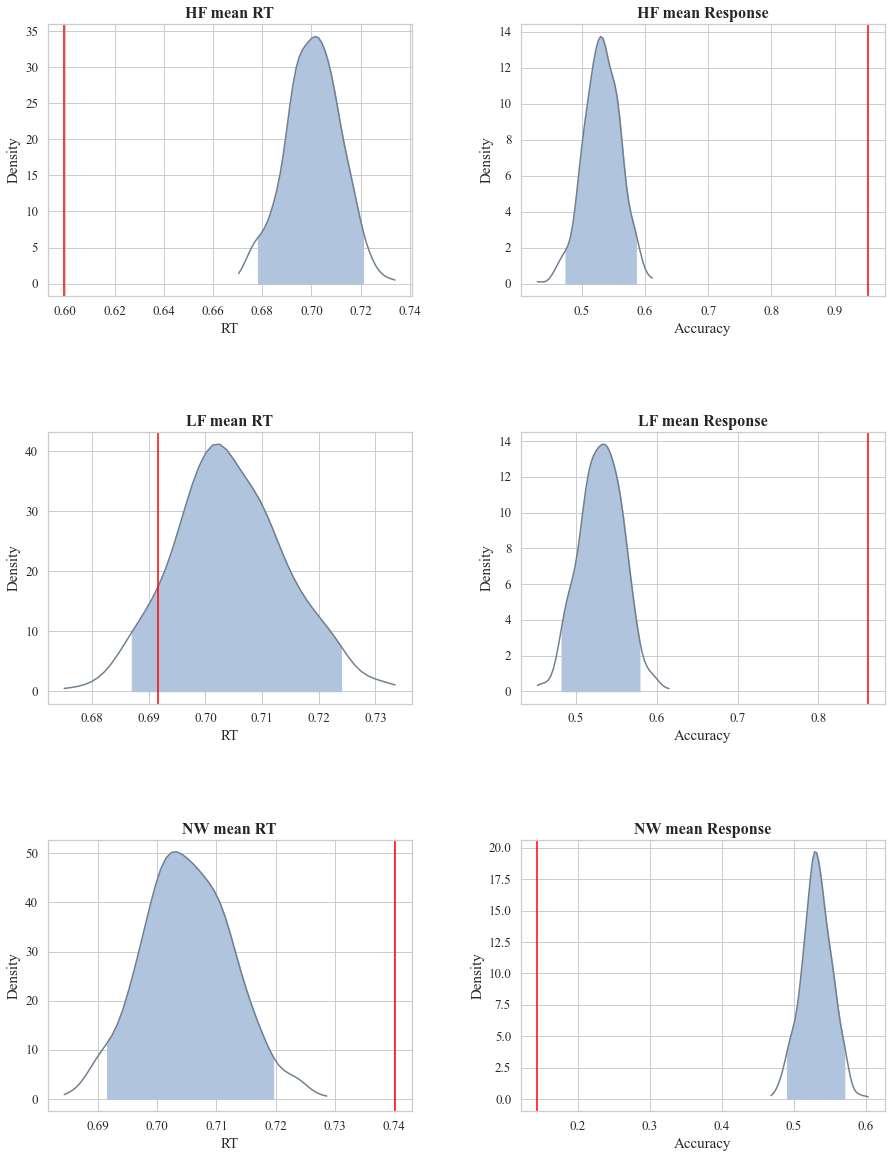

In [46]:
fig, axes = plt.subplots(3,2 , figsize=(15,20))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title('HF mean RT', fontweight="bold", size=16)
axes[0][1].set_title('HF mean Response', fontweight="bold", size=16)
axes[1][0].set_title('LF mean RT', fontweight="bold", size=16)
axes[1][1].set_title('LF mean Response', fontweight="bold", size=16)
axes[2][0].set_title('NW mean RT', fontweight="bold", size=16)
axes[2][1].set_title('NW mean Response', fontweight="bold", size=16)

plot_posterior(HF_pred_rt_mean, HF_data_rt_mean, axes[0][0])
plot_posterior(HF_pred_resp_mean, HF_data_resp_mean, axes[0][1])

plot_posterior(LF_pred_rt_mean, LF_data_rt_mean, axes[1][0])
plot_posterior(LF_pred_resp_mean, LF_data_resp_mean, axes[1][1])

plot_posterior(NW_pred_rt_mean, NW_data_rt_mean, axes[2][0])
plot_posterior(NW_pred_resp_mean, NW_data_resp_mean, axes[2][1])

for ax in axes:
        ax[0].set_xlabel('RT', fontsize=15)
        ax[1].set_xlabel('Accuracy', fontsize=15)
        ax[0].set_ylabel('Density', fontsize=15)
        ax[1].set_ylabel('Density', fontsize=15)
        for tick in ax[0].xaxis.get_major_ticks():
                tick.label.set_fontsize(13)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label.set_fontsize(13)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label.set_fontsize(13)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label.set_fontsize(13) 

plt.savefig(plots_path + 'Mean Accuracy and RT.pdf')